# EDA for usafacts data

Link to the usafacts webpage [here](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [ ]:
# load data
raw = pd.read_csv("../data/01_usafacts_data.csv", encoding="iso-8859-1")

In [3]:
#visualize the top 5 rows
raw.head(5)

,countyFIPS,County Name,State,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,2
2,1015,Calhoun County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,1017,Chambers County,AL,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
4,1043,Cullman County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# visualize the number of columns and rows
raw.shape

(958, 63)

Here is a brief summary of the table:
- countyFIPS is a unique identifier for each county in the US. FIPS stands for Federal Information Processing Standard coding scheme. Since there are confirmed cases that we don't know the county information, their countyFIPS is 0.
- County Name is the name of a county
- State : which state the county belongs to
- stateFIPS: an identifier for the state
- other fields refers to the number of confirmed cases up to a particular date.

In [5]:
# preprocess add a prefix to all the dates in the column names
raw.columns = list(raw.columns[:4]) + ["Date_" + name for name in raw.columns[4:]]

In [6]:
# preprocess check how many rows are there for each (county, state) pair
raw.groupby(
    ['countyFIPS', 'stateFIPS']
)['County Name'].count().reset_index().sort_values(
    'County Name',
    ascending=False,
).head(5)

,countyFIPS,stateFIPS,County Name
770,45061,45,2
859,50023,50,2
263,13243,13,2
196,12063,12,2
0,0,1,1


**Observation : some (county, state) pairs are not unique.**

In [7]:
# visualize the rows that have duplicates
raw[raw['countyFIPS'].isin([45061, 50023, 13243, 12063])]

,countyFIPS,County Name,State,stateFIPS,Date_1/22/2020,Date_1/23/2020,Date_1/24/2020,Date_1/25/2020,Date_1/26/2020,Date_1/27/2020,...,Date_3/11/2020,Date_3/12/2020,Date_3/13/2020,Date_3/14/2020,Date_3/15/2020,Date_3/16/2020,Date_3/17/2020,Date_3/18/2020,Date_3/19/2020,Date_3/20/2020
155,12063,Jackson County,FL,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
156,12063,Jackson County,FL,12,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
224,13243,Richmond County,GA,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,8
225,13243,Randolph County,GA,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
762,45061,Lee County,SC,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
763,45061,Lee County,SC,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
857,50023,Washington County,VT,50,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
858,50023,Washington County,VT,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [8]:
# preprocess add id column
raw['id'] = raw.index

**observation**:
- **Some counties have different names but the same FIPS code.**
- **Some rows have the same FIPS codes and counties but the number of confirmed cases is different.**

In [9]:
# visualize the number of unique counties
print("The number of counties is {}.".format(len(np.unique(raw['countyFIPS']))))

The number of counties is 905.


In [10]:
# preprocess change the table from wide to long format
long = pd.wide_to_long(raw, stubnames='Date', i='id', j='date', sep='_', suffix='.*')
long.columns = list(long.columns[:-1]) + ['confirmed_cases']
long = long.reset_index()
long.head()

,id,date,State,stateFIPS,countyFIPS,County Name,confirmed_cases
0,0,1/22/2020,AL,1,0,Statewide Unallocated,0
1,1,1/22/2020,AL,1,1003,Baldwin County,0
2,2,1/22/2020,AL,1,1015,Calhoun County,0
3,3,1/22/2020,AL,1,1017,Chambers County,0
4,4,1/22/2020,AL,1,1043,Cullman County,0


In [14]:
# preprocess the number of confirmed cases in the US

total = long.groupby('date')['confirmed_cases'].sum().reset_index()
total['date'] = pd.to_datetime(total['date'])
total = total.sort_values('date')

In [22]:
from datetime import timedelta

In [ ]:
datetime.timedel

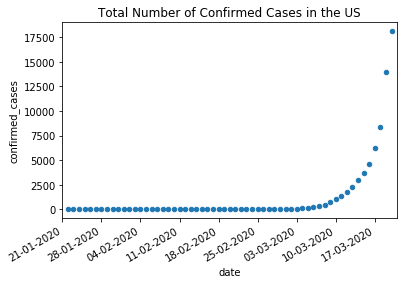

In [27]:
# visualize the total number of confirmed cases in the US

ax = total.plot.scatter('date', 'confirmed_cases')
#ax.scatter( data=total)

# set monthly locator
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_xlim(left=np.min(total['date']) - timedelta(1), right=np.max(total['date'])+timedelta(1))
ax.set_title('Total Number of Confirmed Cases in the US')
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
plt.show()

In [31]:
# visualize the total number of cases at the end
print('The latest total number of cases is {}.'.format(total.iloc[-1]['confirmed_cases']))

The latest total number of cases is 18104.


- That matches with the number reported at the webpage, which is 18149 = 18104 + 45(from grand Princess).